# Extracción ADT
### Script para extraer una sección de los datos de Aviso y guardarlos en un archivo netCDF

In [4]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import dask as dk

from dask.distributed import Client
from os import listdir
from os.path import isfile, join, getsize
import glob

In [5]:
xr.set_options(keep_attrs=True);

In [6]:
client = Client(n_workers=24, threads_per_worker=2, memory_limit=12e9)
client

/home/pvb/miniconda3/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33285 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:39189 Dashboard: http://127.0.0.1:33285/status,Cluster Workers: 24 Cores: 48 Memory: 288.00 GB


## Read all files

In [11]:
ficheros=[]
for ianho in range(1981,2021):
    base_dir='/data/shareddata/Satelite/noaa.oisst.v2.highres/NC/sst.day.mean.{}.nc'.format(ianho)
    fichero=sorted(glob.glob(base_dir)) 
    for ifile in fichero:
        ficheros.append(ifile)

## Load files

In [67]:
time_freq='7'

In [12]:
dsALL = xr.open_mfdataset(ficheros)

In [15]:
dsALL

<xarray.Dataset>
Dimensions:  (lat: 720, lon: 1440, time: 14367)
Coordinates:
  * time     (time) datetime64[ns] 1981-09-01 1981-09-02 ... 2020-12-31
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
Data variables:
    sst      (time, lat, lon) float32 dask.array<chunksize=(122, 720, 1440), meta=np.ndarray>
Attributes:
    Conventions:    CF-1.5
    title:          NOAA High-resolution Blended Analysis: Daily Values using...
    institution:    NOAA/NCDC
    source:         NOAA/NCDC  ftp://eclipse.ncdc.noaa.gov/pub/OI-daily-v2/
    comment:        Reynolds, et al., 2007: Daily High-Resolution-Blended Ana...
    history:        Thu Aug 24 13:34:17 2017: ncatted -O -a References,global...
    dataset_title:  NOAA Daily Optimum Interpolation Sea Surface Temperature
    References:     https://www.psl.noaa.gov/data/gridded/data.noaa.oisst.v2....

In [16]:
#Select area
area_name='NorthAtlantic'
lat_area=slice(0,60)
lon_area=slice(270,360)

In [56]:
sst_area = dsALL.sst.sel(lat=lat_area, lon=lon_area).isel(time=range(1,14365,7))

In [58]:
sst_area

<xarray.DataArray 'sst' (time: 2052, lat: 240, lon: 360)>
dask.array<getitem, shape=(2052, 240, 360), dtype=float32, chunksize=(53, 240, 360), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1981-09-02 1981-09-09 ... 2020-12-23
  * lat      (lat) float32 0.125 0.375 0.625 0.875 ... 59.12 59.38 59.62 59.88
  * lon      (lon) float32 270.1 270.4 270.6 270.9 ... 359.1 359.4 359.6 359.9
Attributes:
    long_name:     Daily Sea Surface Temperature
    units:         degC
    valid_range:   [-3. 45.]
    precision:     2.0
    dataset:       NOAA High-resolution Blended Analysis
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    parent_stat:   Individual Observations
    actual_range:  [-1.8  34.82]

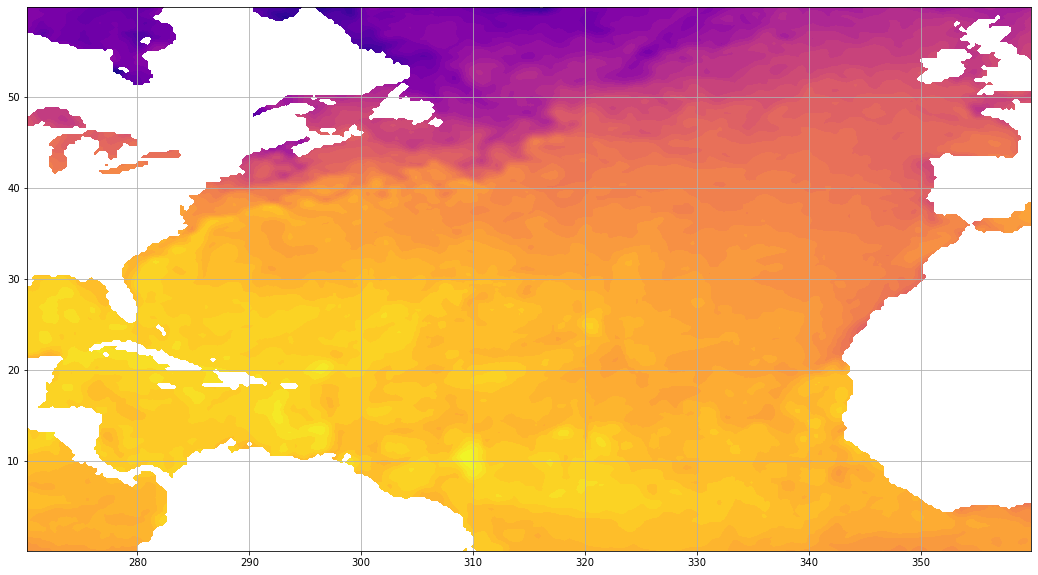

In [59]:
fig, ax= plt.subplots(figsize=(18,10))
ax.contourf(sst_area.lon,sst_area.lat,sst_area.isel(time=0),40,cmap='plasma')
ax.grid()

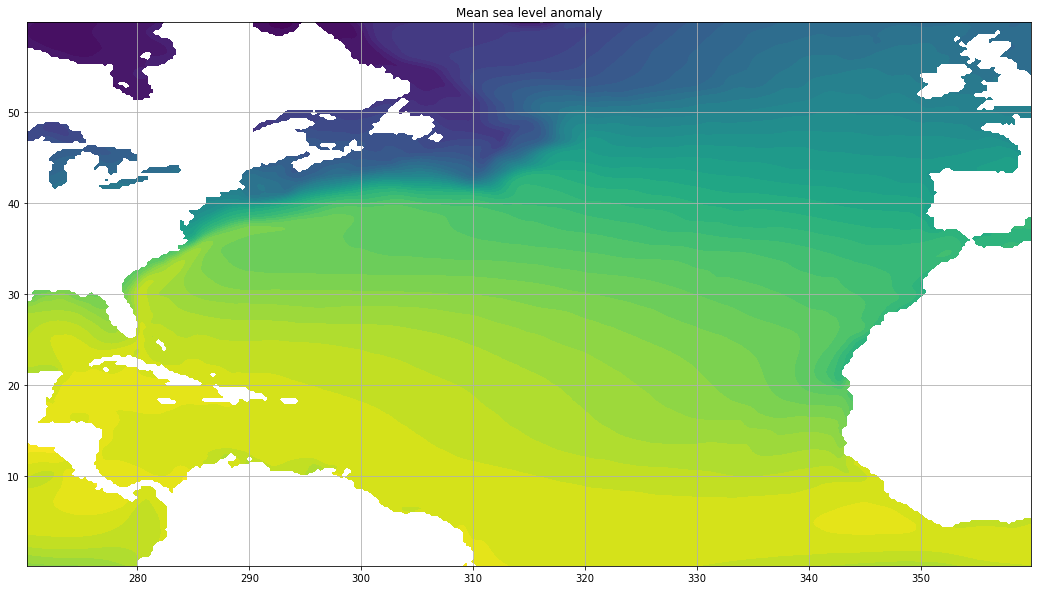

In [60]:
fig, ax= plt.subplots(figsize=(18,10))
ax.contourf(sst_area.lon,sst_area.lat,sst_area.mean(dim='time'),40,cmap='viridis')
ax.set_title('MeanÇ sea level anomaly')
ax.grid()


## Load in memory

In [64]:
sst_area.load()

<xarray.DataArray 'sst' (time: 2052, lat: 240, lon: 360)>
array([[[23.769999 , 23.88     , 23.88     , ..., 25.279999 ,
         25.32     , 25.369999 ],
        [24.08     , 24.17     , 24.22     , ..., 25.189999 ,
         25.24     , 25.39     ],
        [24.289999 , 24.39     , 24.56     , ..., 25.019999 ,
         25.07     , 25.189999 ],
        ...,
        [ 8.57     ,  8.44     ,  8.32     , ..., 12.429999 ,
         12.69     , 12.969999 ],
        [ 8.53     ,  8.41     ,  8.32     , ..., 11.889999 ,
         12.13     , 12.41     ],
        [ 8.66     ,  8.49     ,  8.389999 , ..., 11.23     ,
         11.389999 , 11.599999 ]],

       [[23.189999 , 23.08     , 23.       , ..., 25.369999 ,
         25.439999 , 25.449999 ],
        [23.15     , 23.16     , 23.21     , ..., 25.199999 ,
         25.279999 , 25.32     ],
        [23.279999 , 23.42     , 23.56     , ..., 25.269999 ,
         25.25     , 25.24     ],
...
        [-1.54     , -1.53     , -1.53     , ...,  9.349999 ,
          9.2699995,  9.19     ],
        [-1.56     , -1.55     , -1.55     , ...,  9.29     ,
          9.25     ,  9.179999 ],
        [-1.5799999, -1.5699999, -1.5699999, ...,  9.2699995,
          9.3      ,  9.28     ]],

       [[23.93     , 24.14     , 24.26     , ..., 27.74     ,
         27.75     , 27.75     ],
        [24.189999 , 24.39     , 24.55     , ..., 27.93     ,
         27.92     , 27.88     ],
        [24.47     , 24.63     , 24.769999 , ..., 28.08     ,
         28.039999 , 27.949999 ],
        ...,
        [-1.55     , -1.54     , -1.54     , ...,  9.389999 ,
          9.45     ,  9.51     ],
        [-1.5699999, -1.56     , -1.56     , ...,  9.23     ,
          9.32     ,  9.389999 ],
        [-1.5899999, -1.5799999, -1.5799999, ...,  9.21     ,
          9.29     ,  9.38     ]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1981-09-02 1981-09-09 ... 2020-12-23
  * lat      (lat) float32 0.125 0.375 0.625 0.875 ... 59.12 59.38 59.62 59.88
  * lon      (lon) float32 270.1 270.4 270.6 270.9 ... 359.1 359.4 359.6 359.9
Attributes:
    long_name:     Daily Sea Surface Temperature
    units:         degC
    valid_range:   [-3. 45.]
    precision:     2.0
    dataset:       NOAA High-resolution Blended Analysis
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    parent_stat:   Individual Observations
    actual_range:  [-1.8  34.82]

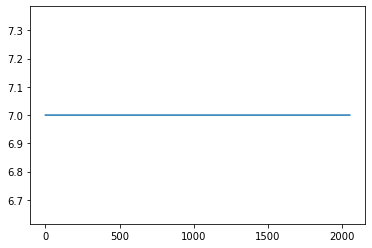

In [66]:
diff = np.diff(sst_area.time)/86400/1e9
plt.plot(diff)

In [68]:
file_out='sst_'+area_name+time_freq+'D.nc'

In [69]:
sst_area.to_netcdf(file_out)